In [1]:
import torch
from pathlib import Path
import os, sys
# Add parent directory to Python path for imports
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

from runners import Runner
from shakespeare_word import load_shakespeare
from utils import get_batch
from collections import defaultdict
from ipywidgets import interact
import ipywidgets as widgets
from scipy.spatial.distance import cdist

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device= torch.device("cpu")

# device = "cpu"
print(f"Using device: {device}")
%load_ext autoreload
%autoreload 2

Using device: mps


In [2]:
text, vocab_size, tokenizer, detokenizer = load_shakespeare("../shakespeare.txt")
print(tokenizer("Good day,\nmy name is verona,\nAnd I am a very good man,verily"))
print(detokenizer(tokenizer("Good day,\nmy name is verona,\nAnd I am a very good man,verily")))

[63, 161, 3, 2, 13, 191, 18, 2571, 3, 2, 6, 8, 85, 11, 162, 63, 88, 3, 4938]
good day,
 my name is Verona,
 and i am a very good man, verily


In [3]:
data = torch.tensor(tokenizer(text))
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]
block_size = 150
batch_size = 50

# Print an example of a training batch
x, y = get_batch(train_data, block_size, batch_size)

In [4]:
import torch
loaded_runner = Runner.load("../saved/shakespeare_transformer_model.pt", tokenizer=tokenizer, detokenizer=detokenizer)
generated_text = loaded_runner.generate("Well, if it be not so, I'll be the first to know it.\n", tokenizer = tokenizer, detokenizer=detokenizer, max_new_tokens=200)
print(generated_text)

, provost. Cyprus persuades have was head;

 PETRUCHIO ourself. would wrongs speak with woe sloth;
 am Thomas is requite in perused thou, who,
 doth concerns relics, Volumnius your stubborn than my brave. — to my that way is much in UNK,
 and dine we dinner, which worse with her hart; in some equal off, and Hymen.
 hence o strong beseeming proceeded ’ bedfellow all Margaret these deadly Antony was leave hope hats brave,
 why today a county those mind outside the Capulets,
 go, and cheerly apparell forth
 where _Kneels john like like some life, UNK a admitted i perpetually.
 that UNK; and husbandry art commonwealth himself presently yourself change win the whispering, and one burden of your father it gentlemen ’ wounded guard,
 with station the duke beyond eyes hates prayer.

 whose likely hares be wond indignities ’ camp?
 now did halfpenny gait minister.
 that merit of blood not,
 this, Jaquenetta, for contradiction Flavius.
 and


In [5]:
def forward_without_last_layer(net, x, include_pos_emb = False):
    """Forward pass through all but the last transformer block"""
    batch_size, seq_len = x.shape
    
    # Get embeddings
    tok_emb = net.token_embedding(x)
    pos_emb = net.position_embedding(torch.arange(seq_len)).unsqueeze(0)
    if include_pos_emb:
        x = tok_emb + pos_emb
    else:
        x = tok_emb
    
    # Pass through all but the last block
    for i in range(len(net.blocks) - 1):
        x = net.blocks[i](x)
    
    return x

In [17]:
from tqdm import tqdm


for _ in tqdm(range(100)):
    x, y = get_batch(train_data, loaded_runner.block_size, 100)
    embeddings = forward_without_last_layer(loaded_runner.net.to("cpu"), x)
    embeddings_flat = embeddings.view(-1, embeddings.shape[-1])

    # Calculate average embeddings for each token
    embedding_avg = defaultdict(lambda: torch.zeros(embeddings.shape[-1]))
    embedding_count = defaultdict(lambda: 0)
    x_flat = x.reshape(-1)
    embeddings_flat = embeddings.reshape(-1, embeddings.shape[-1])

    for token, emb in zip(x_flat, embeddings_flat):
        word = detokenizer([token.item()])
        embedding_avg[word] += emb
        embedding_count[word] += 1


# Compute final averages
embedding_avg = {word: emb / embedding_count[word] 
                for word, emb in embedding_avg.items()}


100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


In [18]:
from sklearn.decomposition import PCA
import numpy as np

words = list(embedding_avg.keys())
X = torch.stack([embedding_avg[w] for w in words]).detach().numpy()
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)  # shape (num_words, 2)

/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/li

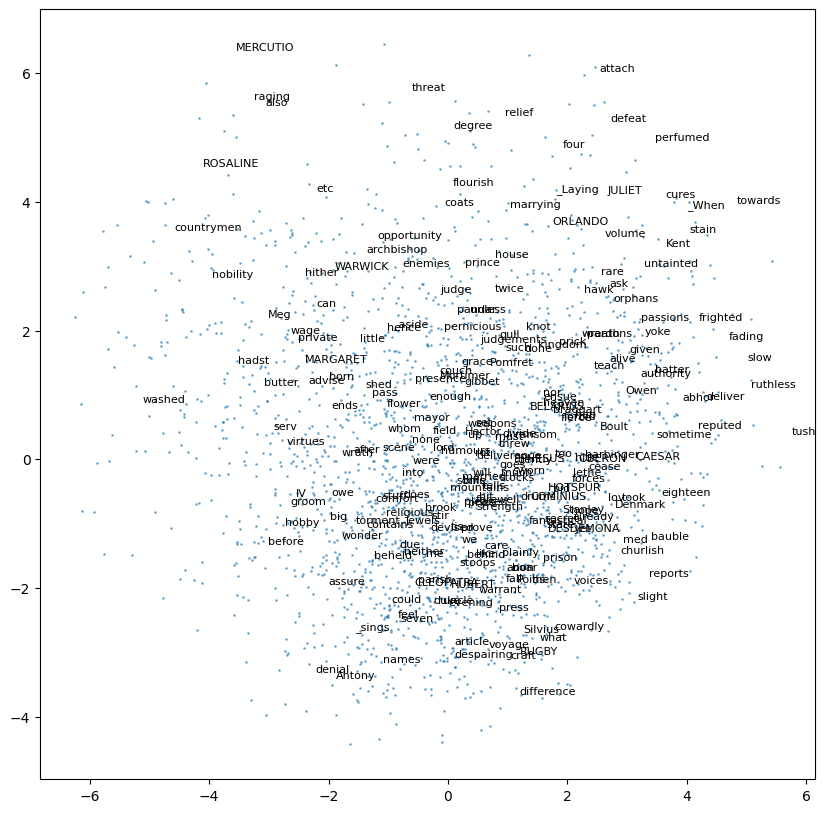

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(X_2d[:,0], X_2d[:,1], s=1, alpha=0.5)

# optionally annotate a few words
for i, word in enumerate(words):
    if i % 10 == 0:  # label every 50th to reduce clutter
        plt.text(X_2d[i,0]+0.5, X_2d[i,1]+0.5, word, fontsize=8)

plt.show()

In [ ]:
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np

def find_nearest_words(x_coord = 0, y_coord = 0, X_2d=X_2d, words=words, n=5):
    point = np.array([[x_coord, y_coord]])
    distances = cdist(point, X_2d)[0]
    nearest_indices = np.argsort(distances)[:n]
    
    nearest_words = [words[i] for i in nearest_indices]
    nearest_distances = distances[nearest_indices]
    
    plt.figure(figsize=(10, 10))
    plt.scatter(X_2d[:,0], X_2d[:,1], s=1, alpha=0.5)
    plt.scatter([x_coord], [y_coord], c='red', marker='+', s=50)
    plt.scatter(X_2d[nearest_indices,0], X_2d[nearest_indices,1], c='red', s=5)

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    
    word_list = "\n".join([f"{w} ({d:.2f})" for w, d in zip(nearest_words, nearest_distances)])
    plt.annotate(word_list, 
                xy=(x_coord, y_coord),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round', fc='yellow', alpha=0.8))
    
    plt.show()
    return nearest_words, nearest_distances

x_min, x_max = float(X_2d[:,0].min()), float(X_2d[:,0].max())
y_min, y_max = float(X_2d[:,1].min()), float(X_2d[:,1].max())

x_slider = widgets.FloatSlider(
    value=float((x_max + x_min) / 2),
    min=x_min,
    max=x_max,
    step=(x_max - x_min) / 100,
    description='X:'
)

y_slider = widgets.FloatSlider(
    value=float((y_max + y_min) / 2),
    min=y_min,
    max=y_max,
    step=(y_max - y_min) / 100,
    description='Y:'
)

# interact(find_nearest_words, x_coord=x_slider, y_coord=y_slider)


TraitError: Invalid selection: value not found

/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


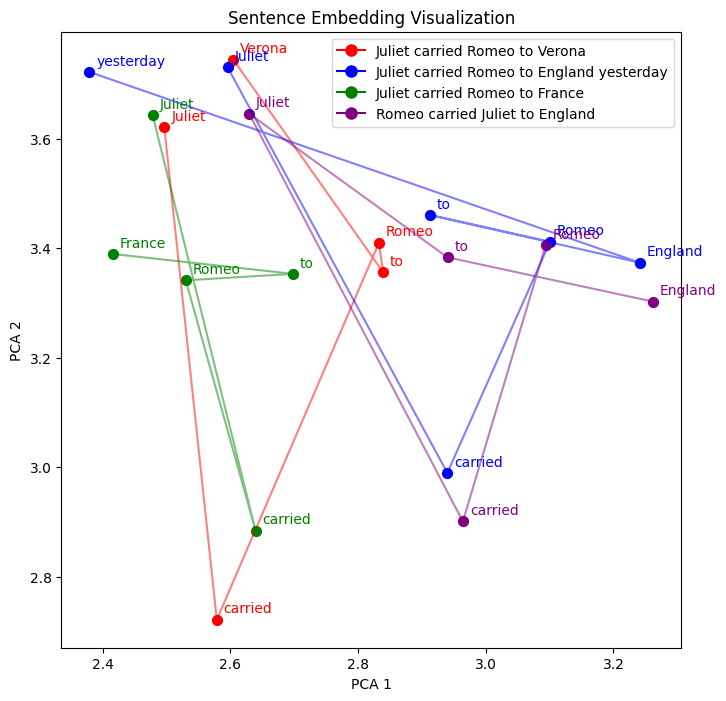

In [ ]:
from ipywidgets import interact, widgets

def get_sentence_embeddings(sentence, tokenizer, block_size, model):
    """Get embeddings for a sentence."""
    tokens = tokenizer(sentence)
    
    # Pad or truncate tokens to match block size
    tokens = tokens[:block_size] if len(tokens) >= block_size else tokens + [0] * (block_size - len(tokens))
    
    # Get embeddings
    x = torch.tensor([tokens])
    with torch.no_grad():
        embeddings = forward_without_last_layer(model.to("cpu"), x)
    return tokens, embeddings

# Test sentences and colors for visualization
test_sentences = [
    "Juliet carried Romeo to Verona",
    "Juliet carried Romeo to England yesterday", 
    "Juliet carried Romeo to France",
    "Romeo carried Juliet to England"
]
colors = ['red', 'blue', 'green', 'purple']

# Get embeddings for all sentences
all_tokens = []
all_embeddings = []
for sentence in test_sentences:
    tokens, embeddings = get_sentence_embeddings(sentence, tokenizer, block_size, loaded_runner.net)
    all_tokens.append(tokens)
    all_embeddings.append(embeddings)

# Project embeddings to 2D
combined_embeddings = torch.cat(all_embeddings).cpu().numpy().reshape(-1, 128)
embeddings_2d = pca.transform(combined_embeddings)

# Create visualization
fig, ax = plt.subplots(figsize=(8,8))

# Plot sentence paths
for sent_idx, (tokens, sentence) in enumerate(zip(all_tokens, test_sentences)):
    start_idx = sent_idx * block_size
    sent_embeddings = embeddings_2d[start_idx:start_idx + block_size]
    
    # Get valid token points (non-padding)
    valid_points = np.array([sent_embeddings[i] for i in range(block_size) if tokens[i] > 1])
    
    if len(valid_points) > 0:
        # Plot path and points
        ax.plot(valid_points[:,0], valid_points[:,1], 
                c=colors[sent_idx], alpha=0.5, linestyle='-')
        ax.scatter(valid_points[:,0], valid_points[:,1],
                  c=colors[sent_idx], s=50)
        
        # Add token labels
        for i, point in enumerate(valid_points):
            ax.annotate(detokenizer([tokens[i]]),
                       xy=(point[0], point[1]),
                       xytext=(5, 5),
                       textcoords='offset points', 
                       color=colors[sent_idx])

# Add labels and legend
ax.set_title('Sentence Embedding Visualization')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color=c, label=s, markersize=8)
                  for c, s in zip(colors, test_sentences)],
         loc='upper right')

plt.show()